In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [ ]:
## Now, we import timm, torchvision image models
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import sys
from tqdm import tqdm
import time
import copy

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [ ]:
dataset_path = "/content/drive/MyDrive/Vision_Transformer/butterly_dataset"

In [ ]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [ ]:
classes = get_classes("/content/drive/MyDrive/Vision_Transformer/butterly_dataset/train")
print(classes, len(classes))

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH', 'Iphiclus si

In [ ]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader), len(val_loader), len(test_loader))

99 16 16


In [ ]:
print(train_data_len, valid_data_len, test_data_len)

12594 500 500


In [ ]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


In [ ]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


In [ ]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=100, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [ ]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize the lists to store the losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # step at end of epoch

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            # store the loss for each phase
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses


In [ ]:
model_ft, train_losses, val_losses = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/29
----------


100%|██████████| 99/99 [12:10<00:00,  7.38s/it]


train Loss: 2.7523 Acc: 0.4781


100%|██████████| 16/16 [00:30<00:00,  1.94s/it]


val Loss: 1.7934 Acc: 0.7640

Epoch 1/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.37it/s]


train Loss: 1.6540 Acc: 0.7849


100%|██████████| 16/16 [00:04<00:00,  3.60it/s]


val Loss: 1.4473 Acc: 0.8640

Epoch 2/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.39it/s]


train Loss: 1.4442 Acc: 0.8550


100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


val Loss: 1.3263 Acc: 0.8900

Epoch 3/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.3451 Acc: 0.8808


100%|██████████| 16/16 [00:03<00:00,  4.58it/s]


val Loss: 1.2534 Acc: 0.9080

Epoch 4/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


train Loss: 1.2846 Acc: 0.8988


100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


val Loss: 1.2365 Acc: 0.9160

Epoch 5/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.2401 Acc: 0.9100


100%|██████████| 16/16 [00:03<00:00,  4.78it/s]


val Loss: 1.2063 Acc: 0.9100

Epoch 6/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.37it/s]


train Loss: 1.2059 Acc: 0.9224


100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


val Loss: 1.1652 Acc: 0.9260

Epoch 7/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.1795 Acc: 0.9300


100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


val Loss: 1.1652 Acc: 0.9140

Epoch 8/29
----------


100%|██████████| 99/99 [01:13<00:00,  1.35it/s]


train Loss: 1.1682 Acc: 0.9310


100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


val Loss: 1.1350 Acc: 0.9340

Epoch 9/29
----------


100%|██████████| 99/99 [01:13<00:00,  1.35it/s]


train Loss: 1.1431 Acc: 0.9397


100%|██████████| 16/16 [00:03<00:00,  4.76it/s]


val Loss: 1.1245 Acc: 0.9360

Epoch 10/29
----------


100%|██████████| 99/99 [01:13<00:00,  1.34it/s]


train Loss: 1.1270 Acc: 0.9427


100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


val Loss: 1.1170 Acc: 0.9260

Epoch 11/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


train Loss: 1.1163 Acc: 0.9445


100%|██████████| 16/16 [00:04<00:00,  3.94it/s]


val Loss: 1.1147 Acc: 0.9500

Epoch 12/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


train Loss: 1.1062 Acc: 0.9495


100%|██████████| 16/16 [00:04<00:00,  3.60it/s]


val Loss: 1.1086 Acc: 0.9380

Epoch 13/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.39it/s]


train Loss: 1.0954 Acc: 0.9521


100%|██████████| 16/16 [00:03<00:00,  4.12it/s]


val Loss: 1.0996 Acc: 0.9420

Epoch 14/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.0889 Acc: 0.9514


100%|██████████| 16/16 [00:03<00:00,  4.65it/s]


val Loss: 1.0906 Acc: 0.9460

Epoch 15/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


train Loss: 1.0781 Acc: 0.9570


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


val Loss: 1.0857 Acc: 0.9420

Epoch 16/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.0684 Acc: 0.9576


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


val Loss: 1.0879 Acc: 0.9540

Epoch 17/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.0685 Acc: 0.9573


100%|██████████| 16/16 [00:03<00:00,  4.73it/s]


val Loss: 1.0931 Acc: 0.9360

Epoch 18/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.37it/s]


train Loss: 1.0606 Acc: 0.9586


100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


val Loss: 1.0755 Acc: 0.9520

Epoch 19/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


train Loss: 1.0492 Acc: 0.9630


100%|██████████| 16/16 [00:03<00:00,  4.78it/s]


val Loss: 1.0744 Acc: 0.9440

Epoch 20/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


train Loss: 1.0486 Acc: 0.9631


100%|██████████| 16/16 [00:03<00:00,  4.59it/s]


val Loss: 1.0787 Acc: 0.9460

Epoch 21/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.37it/s]


train Loss: 1.0446 Acc: 0.9657


100%|██████████| 16/16 [00:03<00:00,  4.32it/s]


val Loss: 1.0660 Acc: 0.9520

Epoch 22/29
----------


100%|██████████| 99/99 [01:13<00:00,  1.35it/s]


train Loss: 1.0386 Acc: 0.9654


100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


val Loss: 1.0659 Acc: 0.9480

Epoch 23/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


train Loss: 1.0336 Acc: 0.9674


100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


val Loss: 1.0816 Acc: 0.9360

Epoch 24/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.0285 Acc: 0.9690


100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


val Loss: 1.0712 Acc: 0.9440

Epoch 25/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.37it/s]


train Loss: 1.0268 Acc: 0.9676


100%|██████████| 16/16 [00:04<00:00,  4.00it/s]


val Loss: 1.0648 Acc: 0.9480

Epoch 26/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.37it/s]


train Loss: 1.0247 Acc: 0.9707


100%|██████████| 16/16 [00:03<00:00,  4.78it/s]


val Loss: 1.0621 Acc: 0.9560

Epoch 27/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


train Loss: 1.0173 Acc: 0.9728


100%|██████████| 16/16 [00:03<00:00,  4.65it/s]


val Loss: 1.0597 Acc: 0.9540

Epoch 28/29
----------


100%|██████████| 99/99 [01:11<00:00,  1.39it/s]


train Loss: 1.0162 Acc: 0.9693


100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


val Loss: 1.0656 Acc: 0.9420

Epoch 29/29
----------


100%|██████████| 99/99 [01:12<00:00,  1.37it/s]


train Loss: 1.0108 Acc: 0.9728


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]

val Loss: 1.0621 Acc: 0.9580

Training complete in 49m 29s
Best Val Acc: 0.9580


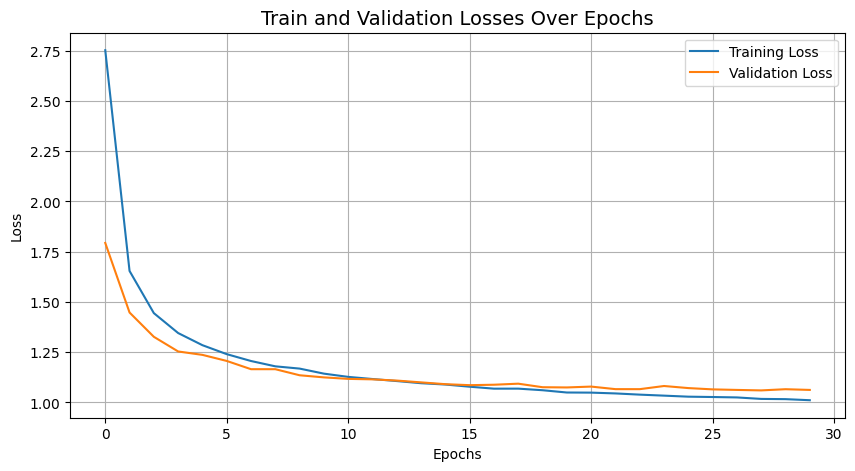

In [ ]:

# Plotting the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 16/16 [00:31<00:00,  1.94s/it]

Test Loss: 0.0398
Test Accuracy of ADONIS: 100% ( 5/ 5)
Test Accuracy of AFRICAN GIANT SWALLOWTAIL: 100% ( 5/ 5)
Test Accuracy of AMERICAN SNOOT: 100% ( 5/ 5)
Test Accuracy of AN 88: 100% ( 5/ 5)
Test Accuracy of APPOLLO: 100% ( 5/ 5)
Test Accuracy of ARCIGERA FLOWER MOTH: 100% ( 5/ 5)
Test Accuracy of ATALA: 100% ( 4/ 4)
Test Accuracy of ATLAS MOTH: 100% ( 5/ 5)
Test Accuracy of BANDED ORANGE HELICONIAN: 100% ( 5/ 5)
Test Accuracy of BANDED PEACOCK: 100% ( 4/ 4)
Test Accuracy of BANDED TIGER MOTH: 75% ( 3/ 4)
Test Accuracy of BECKERS WHITE: 100% ( 5/ 5)
Test Accuracy of BIRD CHERRY ERMINE MOTH: 80% ( 4/ 5)
Test Accuracy of BLACK HAIRSTREAK: 100% ( 5/ 5)
Test Accuracy of BLUE MORPHO: 80% ( 4/ 5)
Test Accuracy of BLUE SPOTTED CROW: 100% ( 5/ 5)
Test Accuracy of BROOKES BIRDWING: 100% ( 4/ 4)
Test Accuracy of BROWN ARGUS: 100% ( 5/ 5)
Test Accuracy of BROWN SIPROETA: 100% ( 4/ 4)
Test Accuracy of CABBAGE WHITE: 100% ( 5/ 5)
Test Accuracy of CAIRNS BIRDWING: 100% ( 5/ 5)
Test Accuracy of 